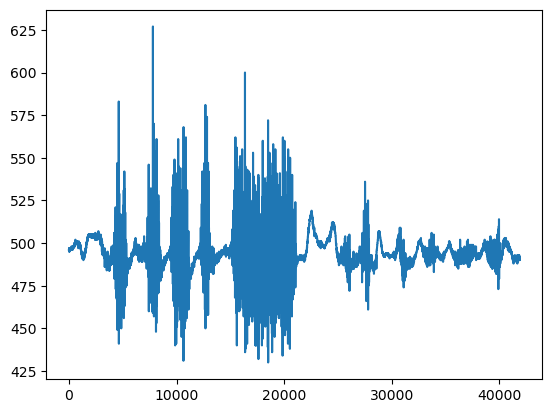

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('raw3.txt', header = None)
data = data.to_numpy()
time = data[0::2]
raw_emg = data[1::2]

plt.plot(time,raw_emg)


In [15]:
print(time[1:10].T)
print(1/np.mean(np.diff(time.T*1e-3)))

[[ 5 11 16 21 26 32 37 43 49]]
180.4206154066506


In [23]:
# band-pass Butterworth filter
from scipy.signal import butter, filtfilt
freq = 1/np.mean(np.diff(time.T*1e-3))
print(([10, 90]/(freq/2)))
b, a = butter(2, ([10, 400]/(freq/2)), btype = 'bandpass')
# dataf = filtfilt(b, a, raw_emg)

[0.11085208 0.9976687 ]


ValueError: Digital filter critical frequencies must be 0 < Wn < 1